In [141]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
import scipy.stats as stats
import xarray as xr
import pdb
import glob
import itertools
import numpy.ma as ma
import salem


pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [142]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


Read the different file types: pb-tags indicate pressure level files, pc-tags indicate pure surface files.
Past is 1980 vegetation, current is 2010. 
Topography and vegetation information is saved in ancillaries folder 'ancils'.

In [291]:
VERA_data_dir = '/media/ck/LStorage/global_water/other/Marian/LAI_experiments/'

wrf_in_green = '/media/ck/LStorage/global_water/other/Marian/LAI_experiments/green/wrfinput_d01'
wrf_in_brown = '/media/ck/LStorage/global_water/other/Marian/LAI_experiments/brown/wrfinput_d01'
day1_diff_2000 = '/media/ck/LStorage/global_water/other/Marian/LAI_experiments/wrf_diff_greenBrown_day1_2011.nc'

In [292]:
wrfg = salem.open_wrf_dataset(wrf_in_green).isel(south_north=slice(0,150), west_east=slice(50,270))
wrfb = salem.open_wrf_dataset(wrf_in_brown).isel(south_north=slice(0,150), west_east=slice(50,270))
diff = xr.open_dataset(day1_diff_2000)
diff = diff.assign_coords({'lon' : wrfg.lon, 'lat' : wrfg.lat})
diff = diff.isel(south_north=slice(0,150), west_east=slice(50,270))

In [264]:
diff = diff.rename({'hour' : 'time'})

In [293]:
vegswitch = ((wrfg['VEGFRA'].isel(time=0)==0) & (wrfb['VEGFRA'].isel(time=0)!=0)).astype(int)

In [305]:
wrfg

<xarray.Dataset>
Dimensions:               (south_north: 150, west_east: 220, time: 1,
                           bottom_top: 44, soil_layers: 3,
                           dust_erosion_dimension: 3, DIM0010: 5, land_cat: 17,
                           soil_cat: 15, num_ext_model_couple_dom: 0,
                           snow_layers: 2, snso_layers: 6,
                           soil_composition_layers: 7, crop_types: 4)
Coordinates:
    lat                   (south_north, west_east) float32 10.22 10.22 ... 17.14
    lon                   (south_north, west_east) float32 -17.68 ... -7.198
  * time                  (time) datetime64[ns] 2000-07-01
  * west_east             (west_east) float64 -1.742e+06 ... -6.475e+05
  * south_north           (south_north) float64 1.073e+06 ... 1.818e+06
Dimensions without coordinates: bottom_top, soil_layers,
                                dust_erosion_dimension, DIM0010, land_cat,
                                soil_cat, num_ext_model_couple_dom,
                                snow_layers, snso_layers,
                                soil_composition_layers, crop_types
Data variables: (12/314)
    LU_INDEX              (time, south_north, west_east) float32 ...
    ZNU                   (time, bottom_top) float32 ...
    ZNW                   (time, bottom_top) float32 ...
    ZS                    (time, soil_layers) float32 ...
    DZS                   (time, soil_layers) float32 ...
    VAR_SSO               (time, south_north, west_east) float32 ...
    ...                    ...
    TK                    (time, bottom_top, south_north, west_east) float32 ...
    WS                    (time, bottom_top, south_north, west_east) float32 ...
    PRESSURE              (time, bottom_top, south_north, west_east) float32 ...
    GEOPOTENTIAL          (time, bottom_top, south_north, west_east) float32 ...
    Z                     (time, bottom_top, south_north, west_east) float32 ...
    SLP                   (time, south_north, west_east) float32 ...
Attributes: (12/91)
    TITLE:                            OUTPUT FROM REAL_EM V4.4 PREPROCESSOR
    START_DATE:                      2000-07-01_00:00:00
    SIMULATION_START_DATE:           2000-07-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        799
    SOUTH-NORTH_GRID_DIMENSION:      426
    BOTTOM-TOP_GRID_DIMENSION:       45
    ...                              ...
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2
    pyproj_srs:                      +proj=merc +lat_ts=20 +lon_0=-1 +x_0=0 +...

In [294]:
def u_v_to_ws_wd(u,v):
    """
    This function computes wind speed and wind direction from given u,v wind components
    Wind direction indicates where the wind is coming from. 
    :param u:
    :param v:
    :return: tuple (wind speed, wind direction (convention "wind coming from")
    """

    ws = np.array(np.sqrt(u*u + v*v))
    wd = np.array(180. + np.arctan2(u, v) * 180./ np.pi)  # dir where wind is coming from
    pos = np.where(ws == 0)
    try:
        wd[pos] = np.nan
    except IndexError:
        pass

    return ws,wd

In [295]:
ucur = diff['U10']   # data for wind example
vcur = diff['V10']

In [296]:
## a clean way of plotting - use matplotlib functions directly:

def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'], linewidths=0.5 )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
  

In [297]:
import matplotlib.patches as patches
def draw_map_pixel(ax, t, lat, lon, title='', clabel='', cmap='RdBu_r', **kwargs):
    
    plt.pcolormesh(lon, lat, t, transform=ccrs.PlateCarree(), cmap=cmap, **kwargs)
    ax.coastlines()
    
    
    # Gridlines
    xl = ax.gridlines(draw_labels=True, linewidth=0.5, color='grey', linestyle='dashed');
    #ax.set_xticks(np.arange(-140,161,20), minor=True)
    plt.grid(which='minor')
    
    xl.top_labels = False
    xl.right_labels = False
    xl.xlines = False
    xl.ylines=False
    # Countries
    #ax.add_feature(cartopy.feature.BORDERS, linestyle='--', color='grey', linewidth=0.5);
    
    #rect2 = patches.Rectangle((box[0],box[2]),box[1]-box[0],box[3]-box[2],linewidth=0.8,edgecolor='w',facecolor='none', zorder=99)
        
    #ax.add_patch(rect2)
    
    plt.title(title)
    cbar = plt.colorbar()
    cbar.set_label(clabel)

In [298]:
from utils import u_plot
norm = u_plot.discrete_cmap_norm([-1,1,10], 'jet')

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right at

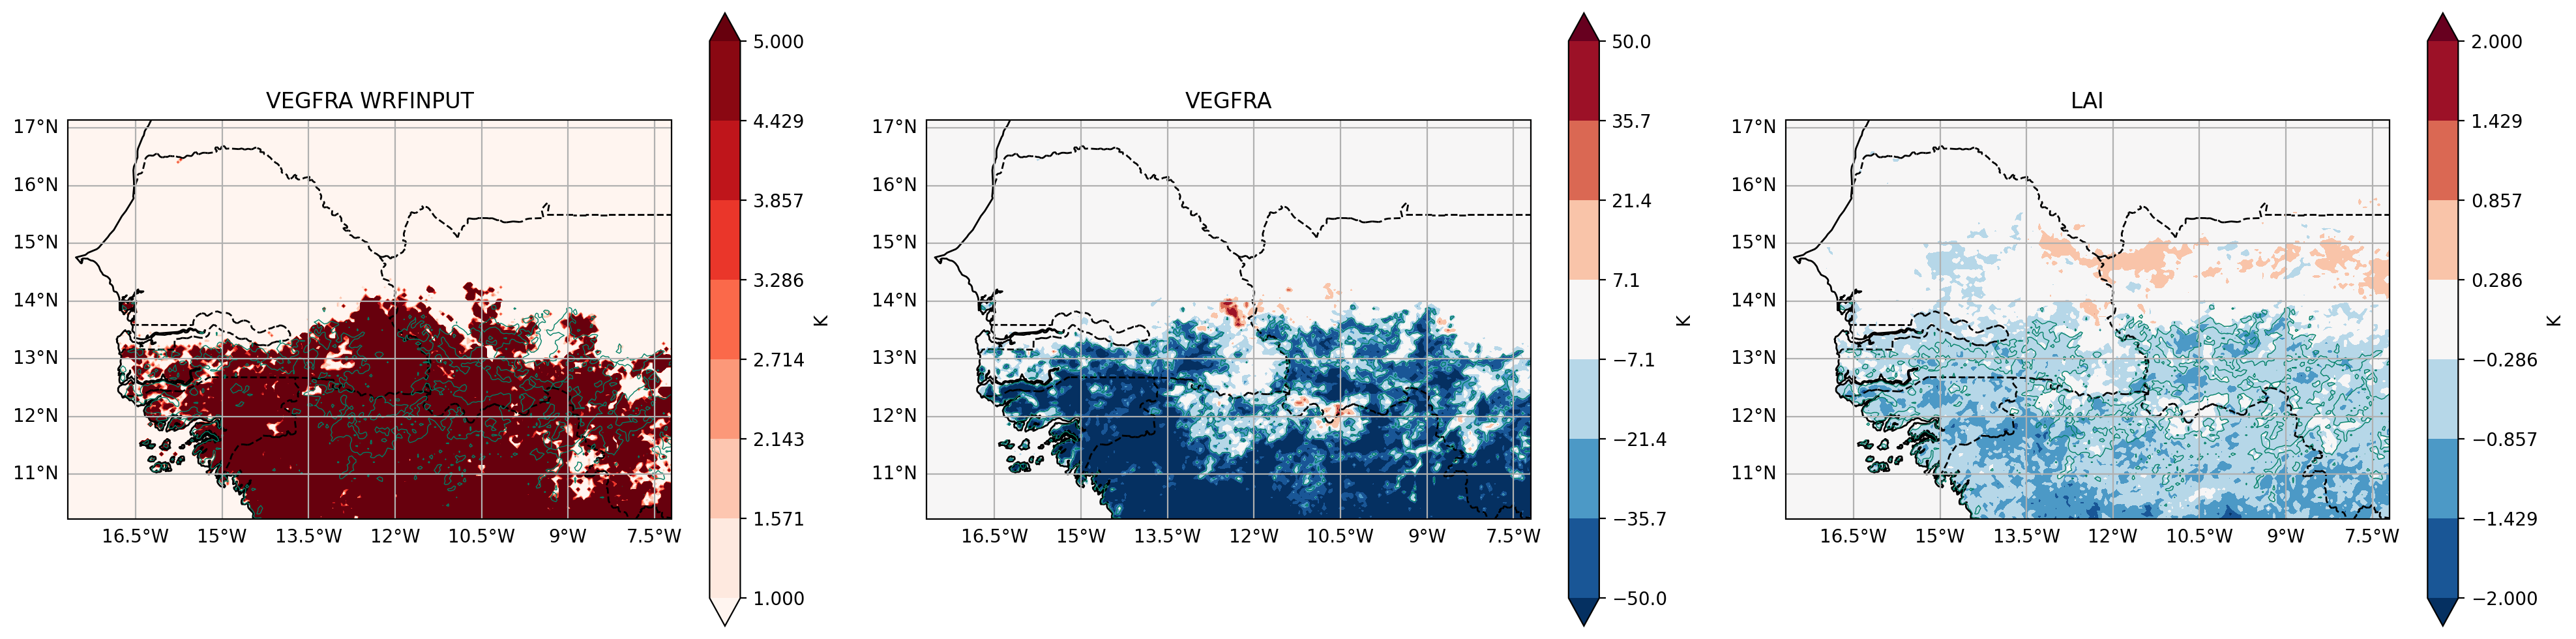

In [311]:
lon=diff.lon
lat=diff.lat
f = plt.figure(figsize=(20,5), dpi=200)

ax = f.add_subplot(131, projection=ccrs.PlateCarree())
time_id = 5
data=wrfg['VEGFRA'].isel(time=0)
data2=diff['VEGFRA'].isel(time=time_id)

contour = {'data' : data2, 'x' : lon, 'y' : lat, 'levels' : [-101,-30], 'cmap' : 'summer_r'}

title='VEGFRA WRFINPUT'
draw_map(ax , data, lon, lat, title=title, levels=np.linspace(1,5,8), extend='both', cmap='Reds', contour=contour, cbar_label= 'K')

ax = f.add_subplot(132, projection=ccrs.PlateCarree())
time_id = 1
data=diff['VEGFRA'].isel(time=time_id)
data2=diff['VEGFRA'].isel(time=time_id)

contour = {'data' : data2, 'x' : lon, 'y' : lat, 'levels' : [-101,-30], 'cmap' : 'summer_r'}

title='VEGFRA'
draw_map(ax, data, lon, lat, title=title, levels=np.linspace(-50,50,8), extend='both', cmap='RdBu_r', contour=contour, cbar_label= 'K')


ax = f.add_subplot(133, projection=ccrs.PlateCarree())
time_id = 5
data=diff['LAI'].isel(time=time_id)
data2=diff['VEGFRA'].isel(time=time_id)

contour = {'data' : data2, 'x' : lon, 'y' : lat, 'levels' : [-101,-30], 'cmap' : 'summer_r'}

title='LAI'
draw_map(ax , data, lon, lat, title=title, levels=np.linspace(-2,2,8), extend='both', cmap='RdBu_r', contour=contour, cbar_label= 'K')
## Note that rainfall differences are very noisy!
## Note also that we barely get any rainfall at all (current or past!) in the deforestation region in our simulations..
plt.tight_layout()

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right at

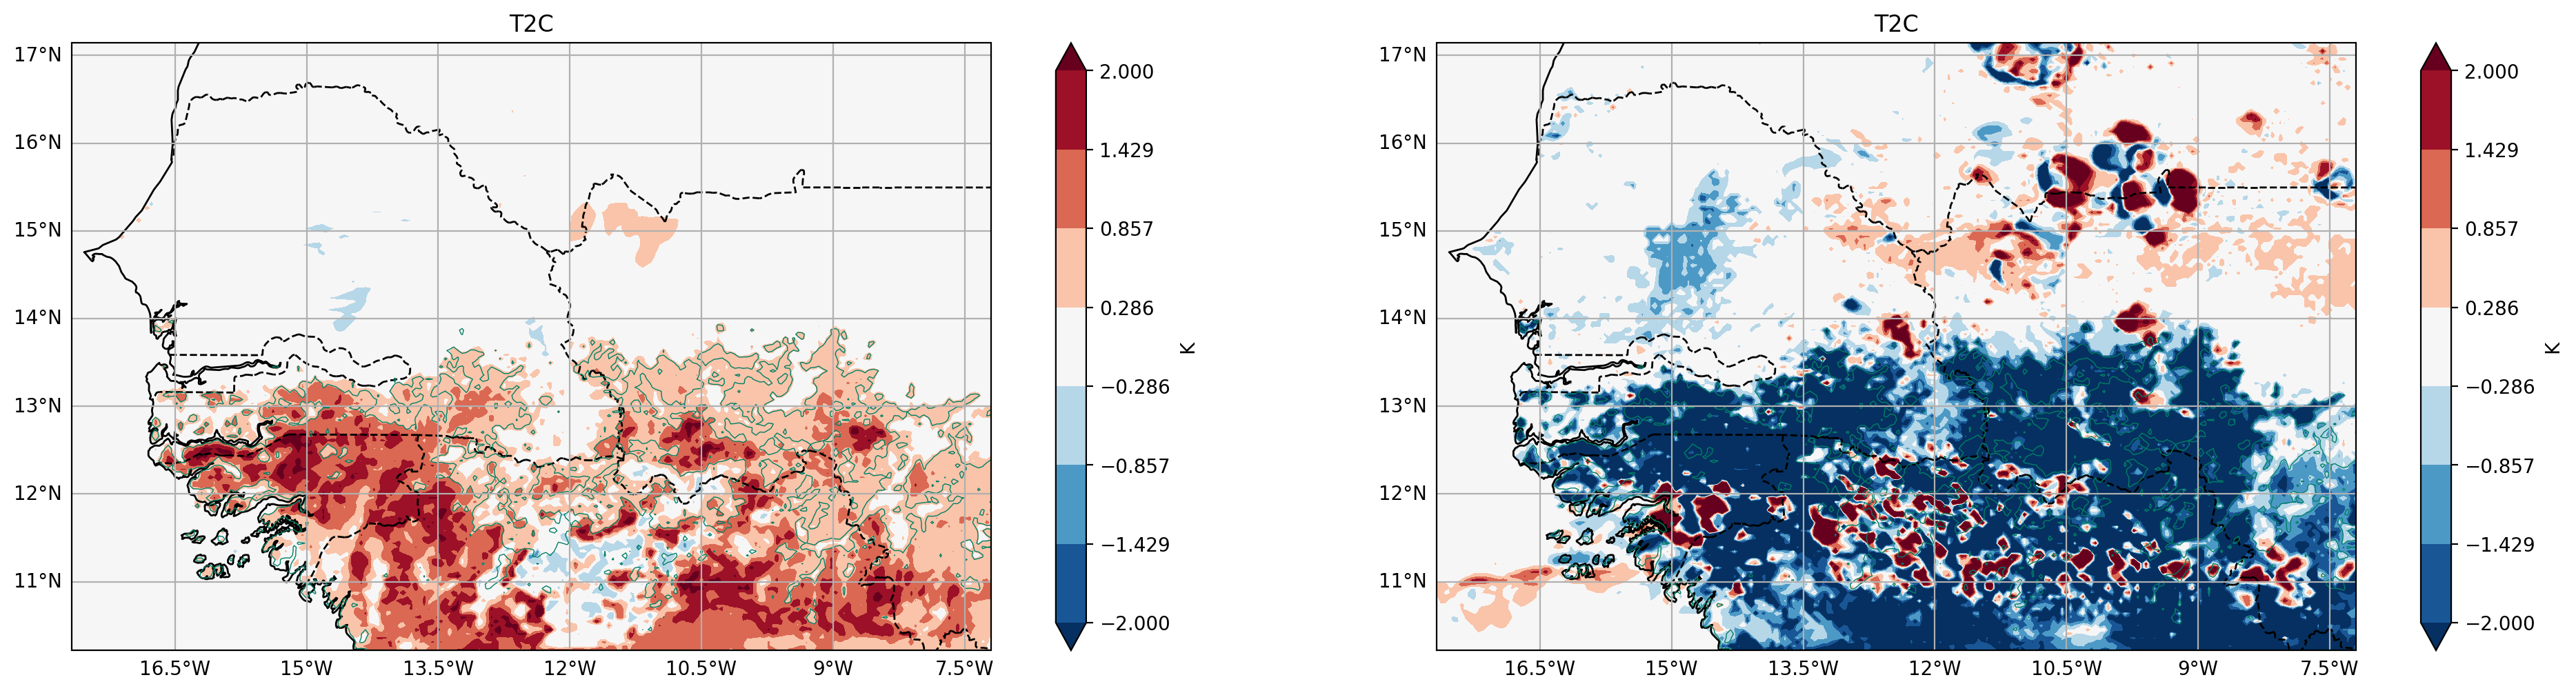

In [300]:
lon=diff.lon
lat=diff.lat
f = plt.figure(figsize=(20,5), dpi=200)

ax = f.add_subplot(121, projection=ccrs.PlateCarree())
time_id = 1
data=diff['T2C'].isel(time=time_id)
data2=diff['VEGFRA'].isel(time=time_id)

contour = {'data' : data2, 'x' : lon, 'y' : lat, 'levels' : [-101,-30], 'cmap' : 'summer_r'}

title='T2C'
draw_map(ax, data, lon, lat, title=title, levels=np.linspace(-2,2,8), extend='both', cmap='RdBu_r', contour=contour, cbar_label= 'K')


ax = f.add_subplot(122, projection=ccrs.PlateCarree())
time_id = 5
data=diff['T2C'].isel(time=time_id)
data2=diff['VEGFRA'].isel(time=time_id)

contour = {'data' : data2, 'x' : lon, 'y' : lat, 'levels' : [-101,-30], 'cmap' : 'summer_r'}

title='T2C'
draw_map(ax , data, lon, lat, title=title, levels=np.linspace(-2,2,8), extend='both', cmap='RdBu_r', contour=contour, cbar_label= 'K')
## Note that rainfall differences are very noisy!
## Note also that we barely get any rainfall at all (current or past!) in the deforestation region in our simulations..
plt.tight_layout()

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right at

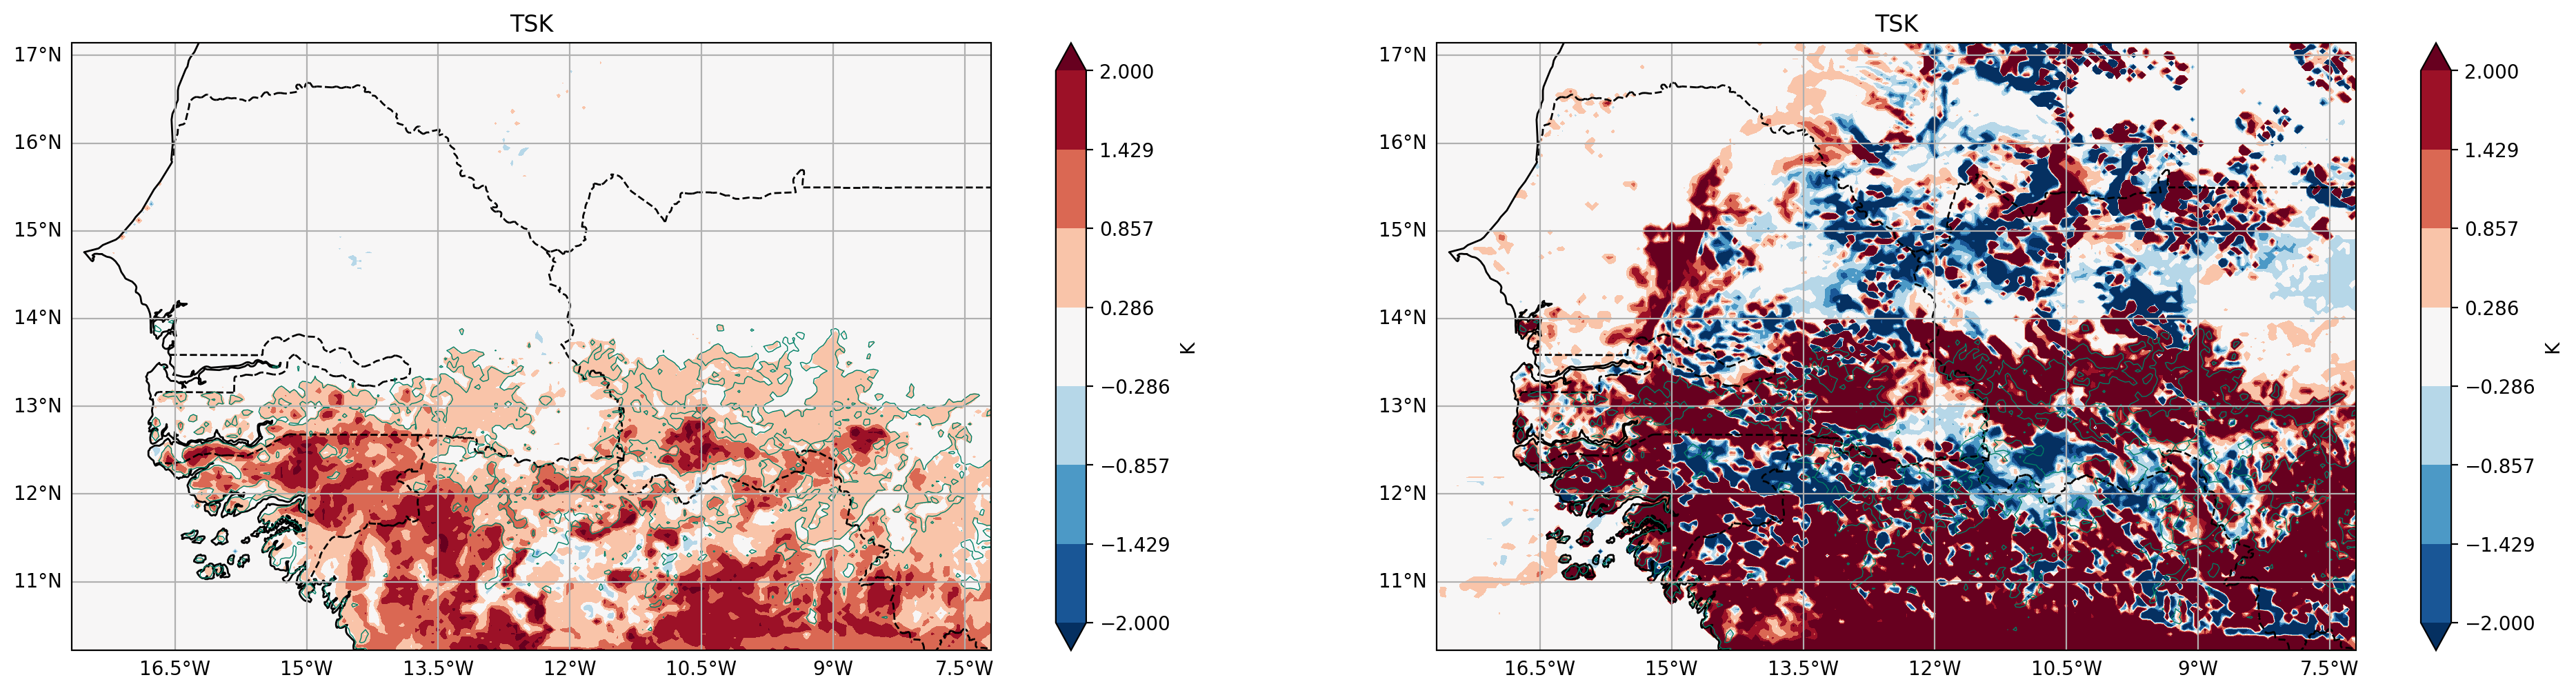

In [301]:
lon=diff.lon
lat=diff.lat
f = plt.figure(figsize=(20,5), dpi=200)

ax = f.add_subplot(121, projection=ccrs.PlateCarree())
time_id = 1
data=diff['TSK'].isel(time=time_id)
data2=diff['VEGFRA'].isel(time=time_id)

contour = {'data' : data2, 'x' : lon, 'y' : lat, 'levels' : [-101,-30], 'cmap' : 'summer_r'}

title='TSK'
draw_map(ax, data, lon, lat, title=title, levels=np.linspace(-2,2,8), extend='both', cmap='RdBu_r', contour=contour, cbar_label= 'K')


ax = f.add_subplot(122, projection=ccrs.PlateCarree())
time_id = 5
data=diff['TSK'].isel(time=time_id)
data2=diff['VEGFRA'].isel(time=time_id)

contour = {'data' : data2, 'x' : lon, 'y' : lat, 'levels' : [-101,-30], 'cmap' : 'summer_r'}

title='TSK'
draw_map(ax , data, lon, lat, title=title, levels=np.linspace(-2,2,8), extend='both', cmap='RdBu_r', contour=contour, cbar_label= 'K')
## Note that rainfall differences are very noisy!
## Note also that we barely get any rainfall at all (current or past!) in the deforestation region in our simulations..
plt.tight_layout()

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right at

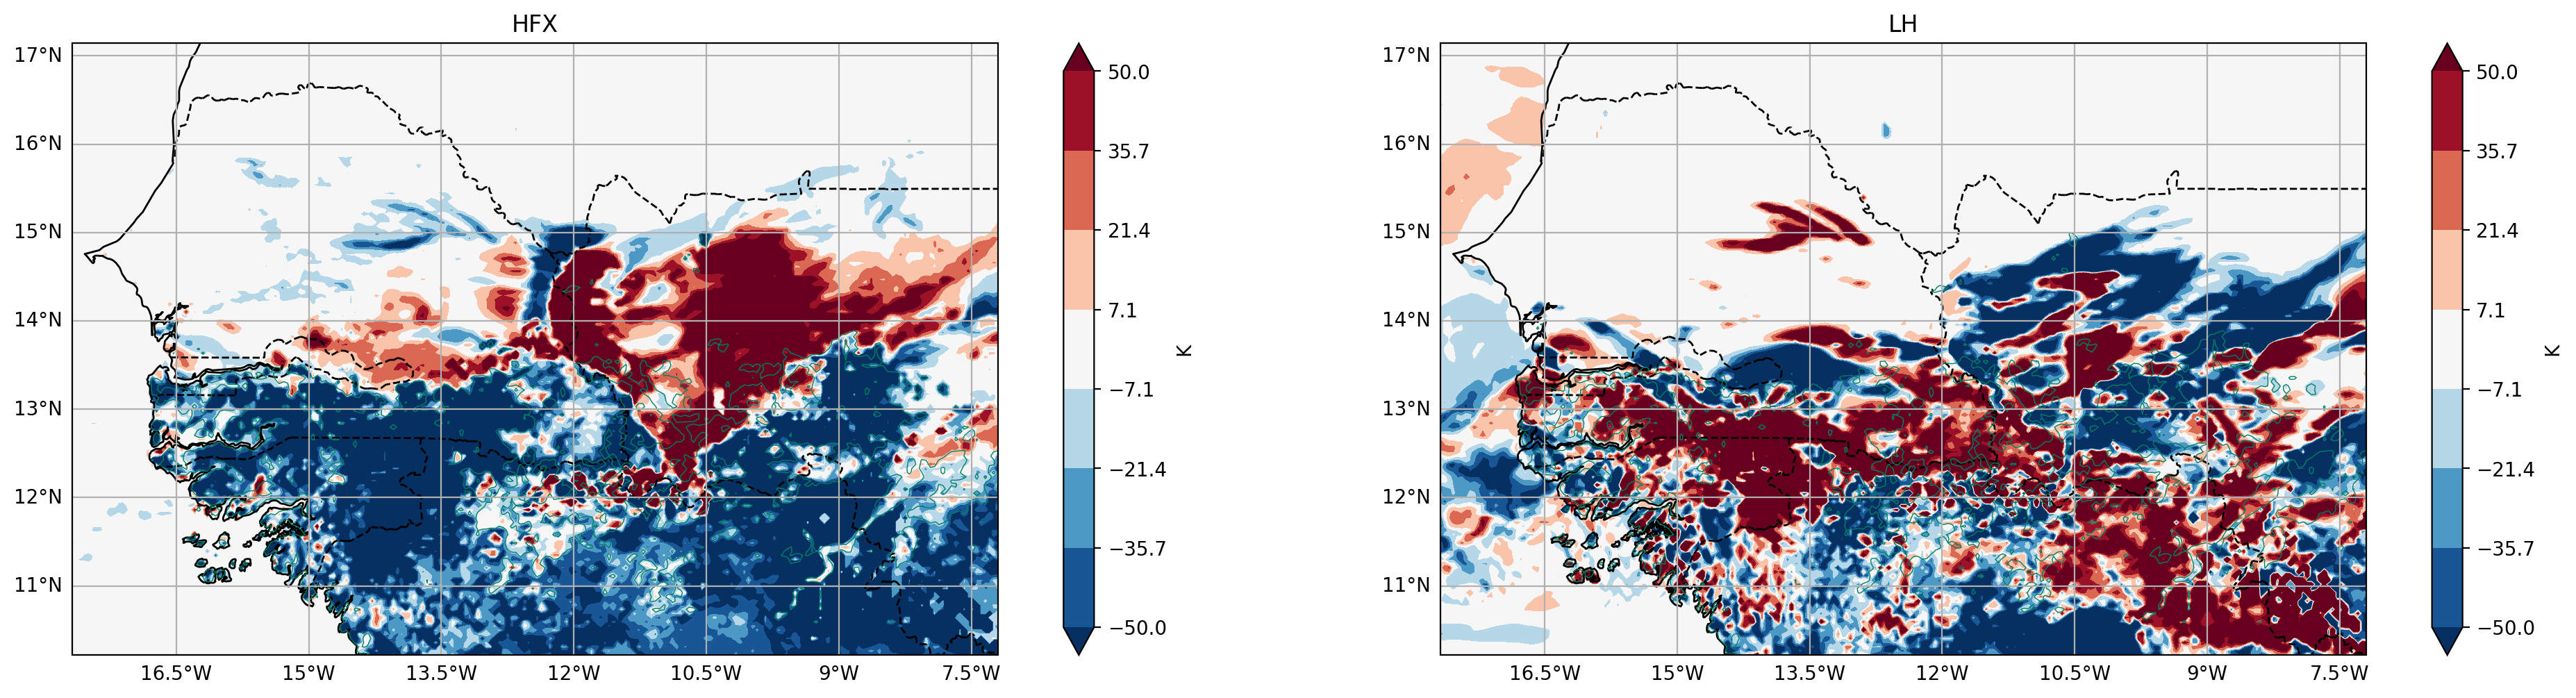

In [290]:
lon=diff.lon
lat=diff.lat
f = plt.figure(figsize=(20,5), dpi=200)

ax = f.add_subplot(121, projection=ccrs.PlateCarree())
time_id = 4
data=diff['HFX'].isel(time=time_id)
data2=diff['VEGFRA'].isel(time=time_id)

contour = {'data' : data2, 'x' : lon, 'y' : lat, 'levels' : [-101,-30], 'cmap' : 'summer_r'}

title='HFX'
draw_map(ax, data, lon, lat, title=title, levels=np.linspace(-50,50,8), extend='both', cmap='RdBu_r', contour=contour, cbar_label= 'K')


ax = f.add_subplot(122, projection=ccrs.PlateCarree())
time_id = 4
data=diff['LH'].isel(time=time_id)
data2=diff['VEGFRA'].isel(time=time_id)

contour = {'data' : data2, 'x' : lon, 'y' : lat, 'levels' : [-101,-30], 'cmap' : 'summer_r'}

title='LH'
draw_map(ax , data, lon, lat, title=title, levels=np.linspace(-50,50,8), extend='both', cmap='RdBu_r', contour=contour, cbar_label= 'K')
## Note that rainfall differences are very noisy!
## Note also that we barely get any rainfall at all (current or past!) in the deforestation region in our simulations..
plt.tight_layout()

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right at

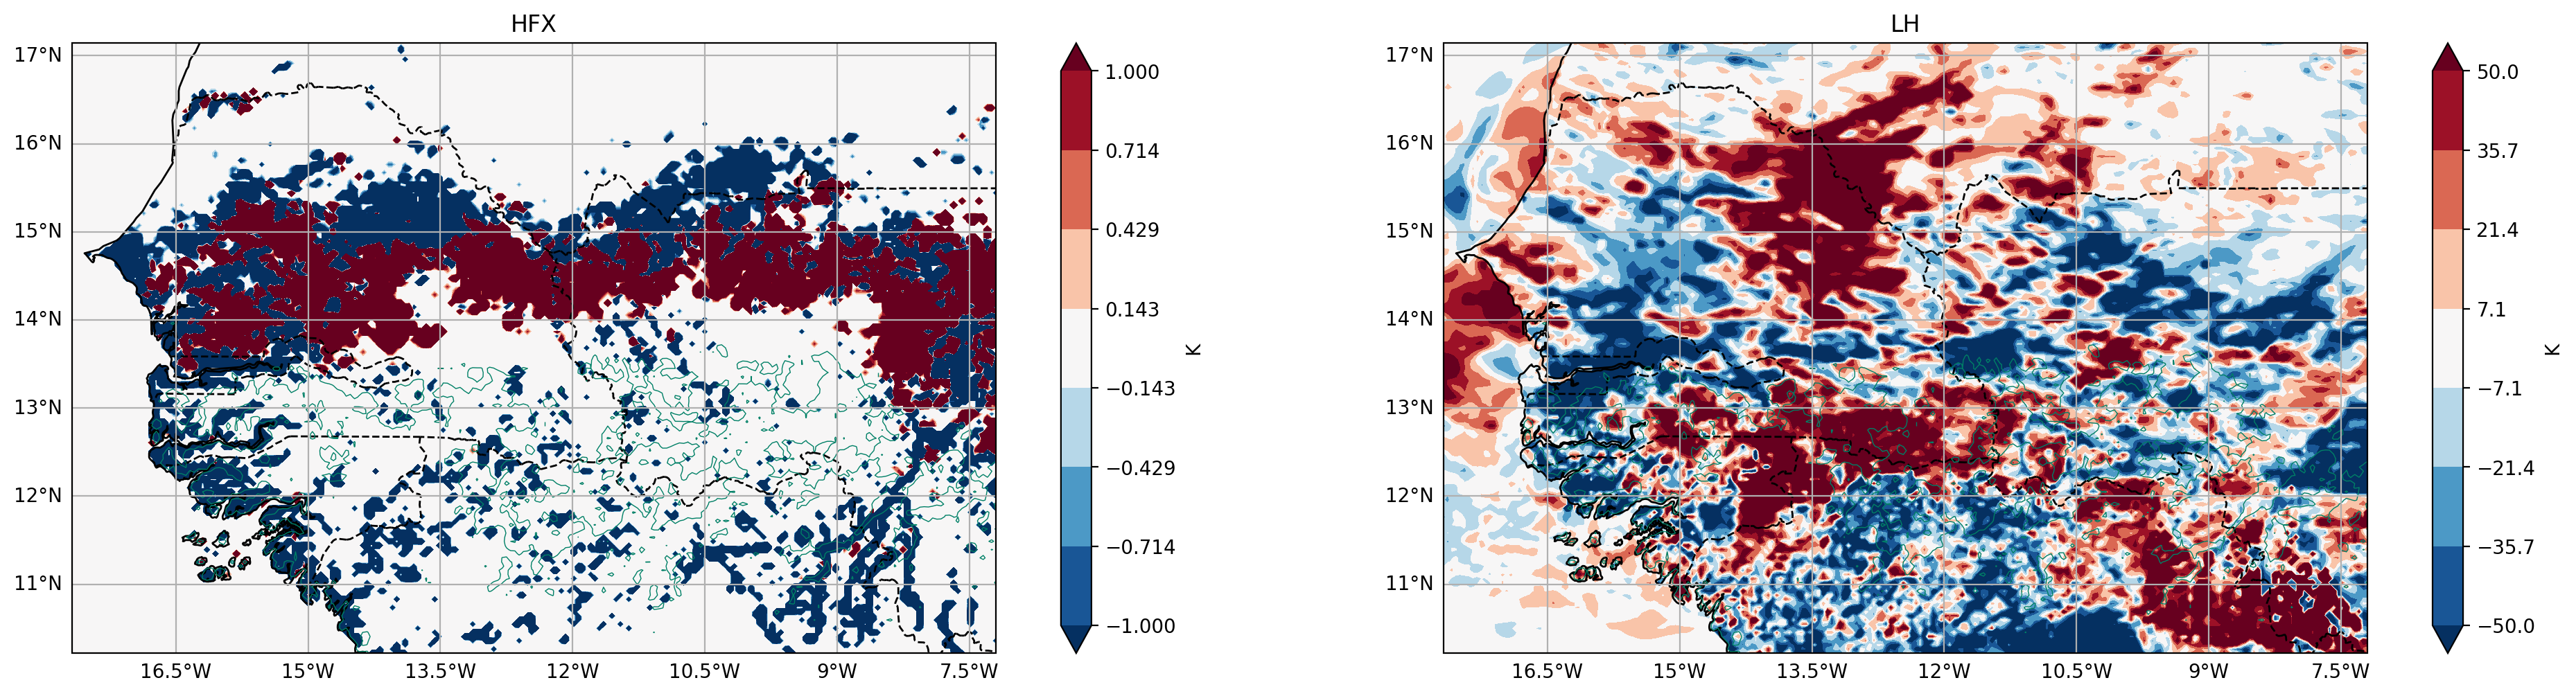

In [275]:
lon=diff.lon
lat=diff.lat
f = plt.figure(figsize=(20,5), dpi=200)

ax = f.add_subplot(121, projection=ccrs.PlateCarree())
time_id = 5
data=diff['SHDMAX'].isel(time=time_id)
data2=diff['VEGFRA'].isel(time=time_id)

contour = {'data' : data2, 'x' : lon, 'y' : lat, 'levels' : [-101,-30], 'cmap' : 'summer_r'}

title='HFX'
draw_map(ax, data, lon, lat, title=title, levels=np.linspace(-1,1,8), extend='both', cmap='RdBu_r', contour=contour, cbar_label= 'K')


ax = f.add_subplot(122, projection=ccrs.PlateCarree())
time_id = 4
data=diff['LH'].isel(time=time_id)
data2=diff['VEGFRA'].isel(time=time_id)

contour = {'data' : data2, 'x' : lon, 'y' : lat, 'levels' : [-101,-30], 'cmap' : 'summer_r'}

title='LH'
draw_map(ax , data, lon, lat, title=title, levels=np.linspace(-50,50,8), extend='both', cmap='RdBu_r', contour=contour, cbar_label= 'K')
## Note that rainfall differences are very noisy!
## Note also that we barely get any rainfall at all (current or past!) in the deforestation region in our simulations..
plt.tight_layout()

/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


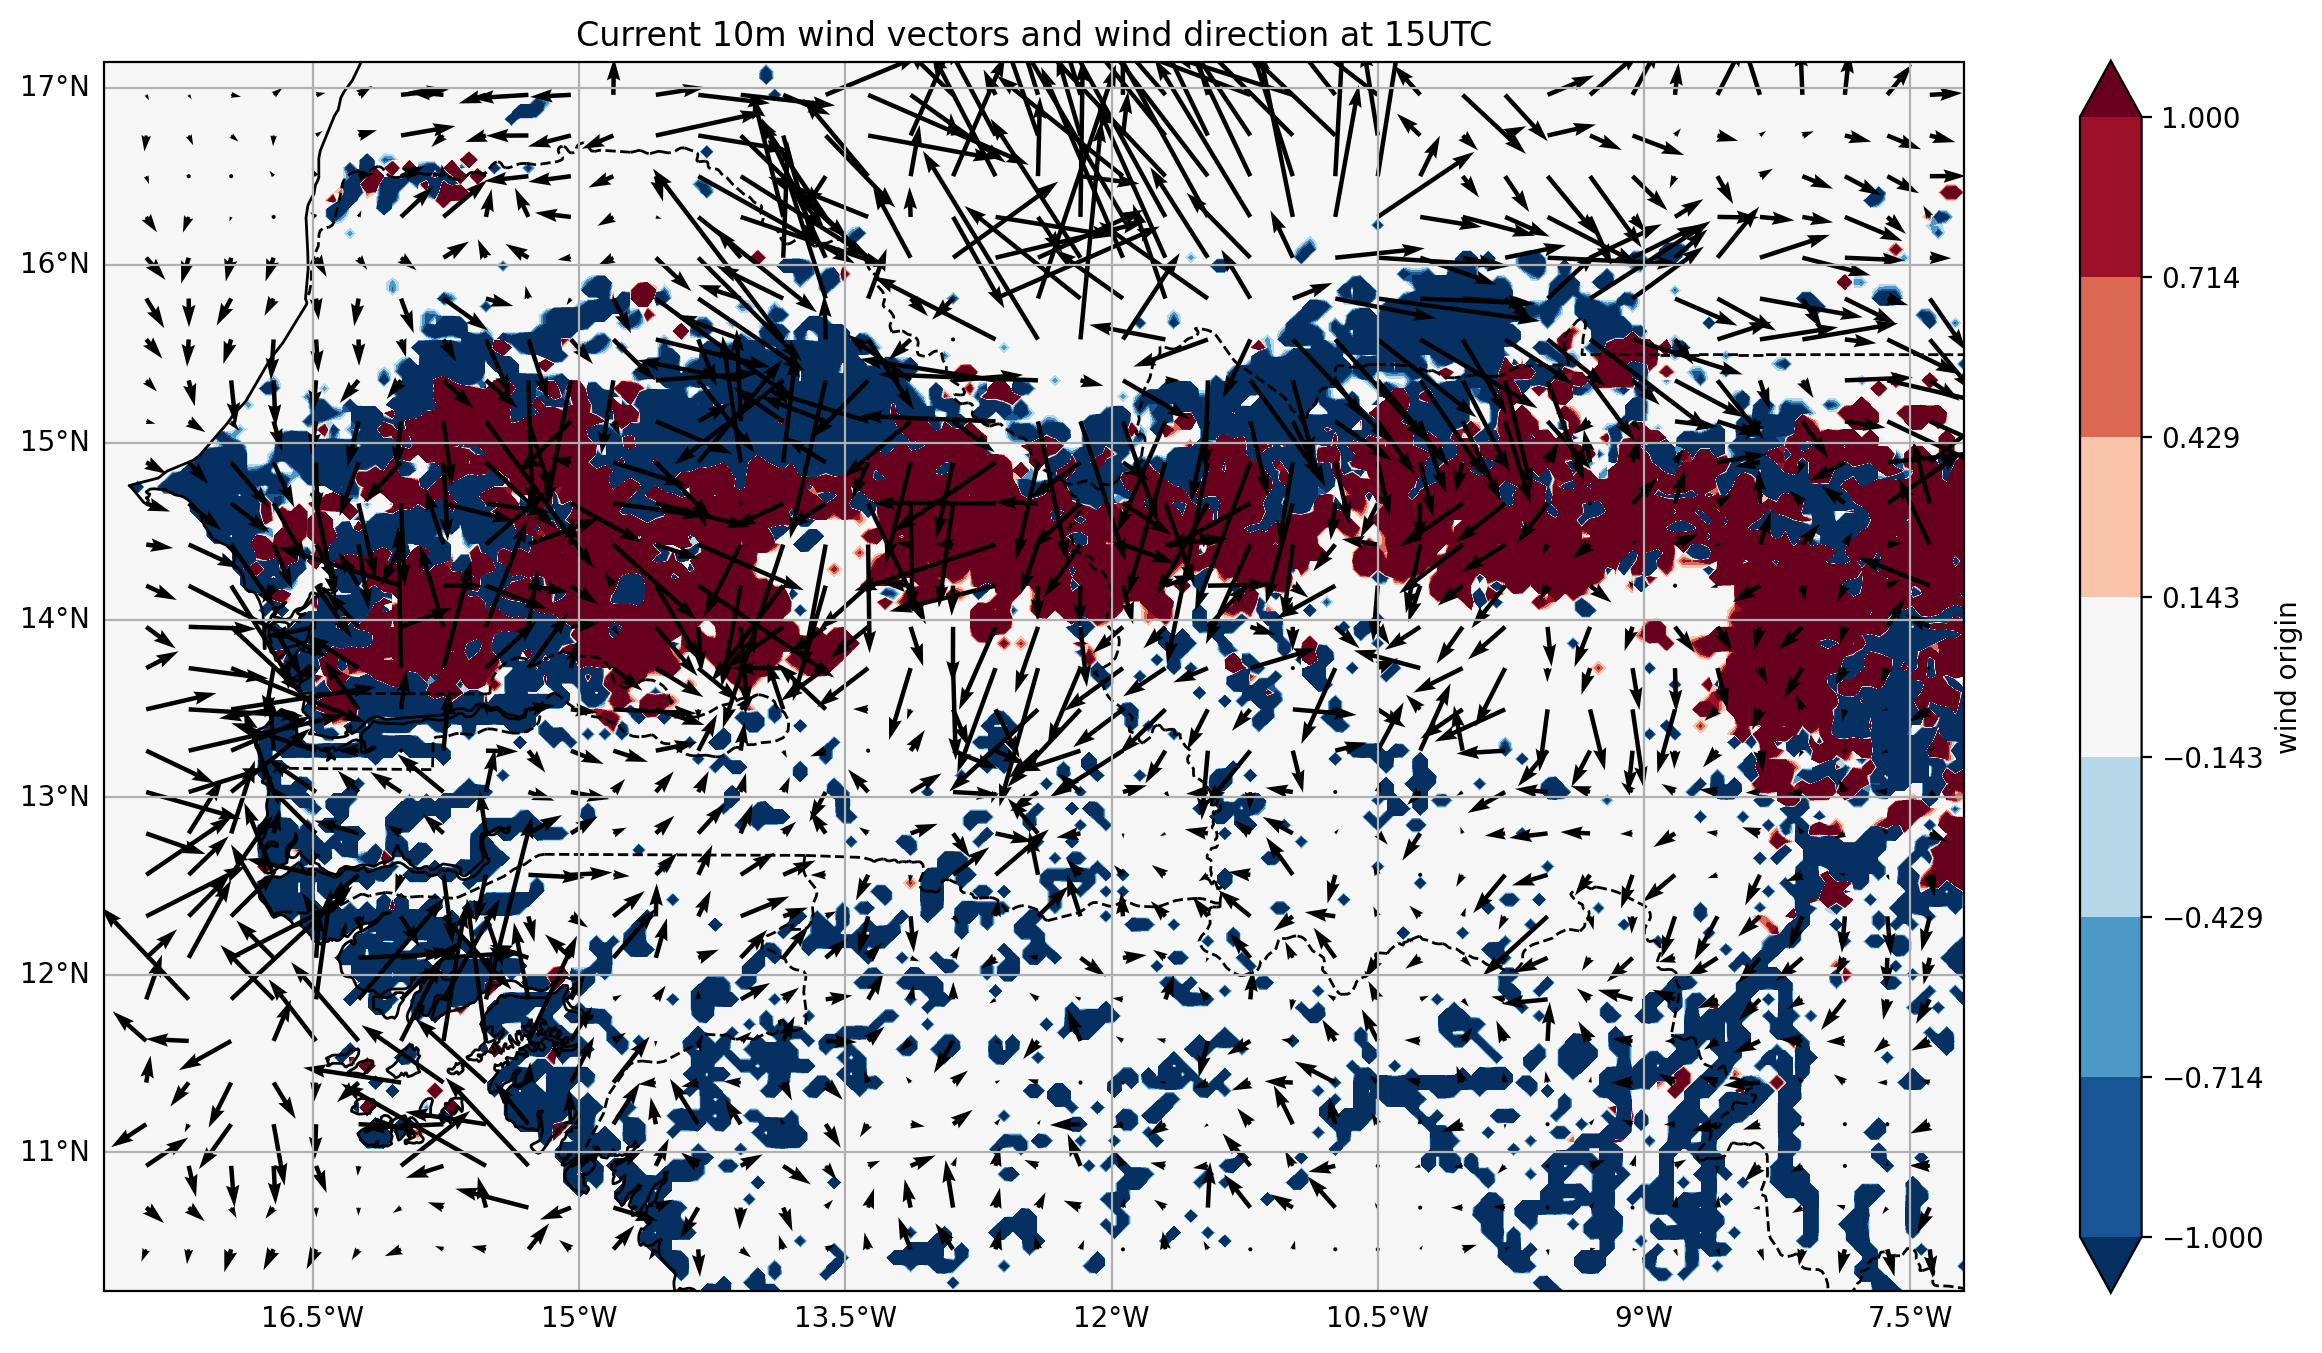

In [276]:
# preparation of wind vector data in plot
st=5
sarrow = 5

time_id = 1

xquiv = diff.lon[sarrow::st, sarrow::st]
yquiv = diff.lat[sarrow::st, sarrow::st]

uu = (ucur.isel(time=time_id))[sarrow::st, sarrow::st]
vv = (vcur.isel(time=time_id))[sarrow::st, sarrow::st]

f = plt.figure(figsize=(15,8), dpi=200)

ax = f.add_subplot(111, projection=ccrs.PlateCarree())

data=diff['SHDMAX'].isel(time=time_id)

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : vv, 'scale' : 50}

draw_map(ax, data, diff.lon, diff.lat, title='Current 10m wind vectors and wind direction at 15UTC', quiver=qin, levels=np.linspace(-1,1,8), cbar_label='wind origin', cmap='RdBu_r', extend='both')

In [44]:
## a clean way of plotting - use matplotlib functions directly:

def draw_cross(data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, twinx=None, **kwargs):
    f=plt.figure(figsize=(15,7))  # this opens a plot window
    ax = f.add_subplot(111)  # this opens a new plot axis
    mapp = ax.contourf(lon, lat, data, **kwargs, extend='both')  # this is the actual plot
    plt.gca().invert_yaxis()
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
        
    if contour is not None:
        cs = ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        plt.clabel(cs, inline=1, fontsize=10)
        
    if twinx is not None:
        ax1 = ax.twinx()
        ax1.plot(twinx['x'], twinx['y'], twinx['color'] )
        ax1.set_ylabel(twinx['ylabel'])
        ax1.set_ylim(twinx['ylim'][0], twinx['ylim'][1])
    
    plt.title(title)
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)
    plt.show() 

In [45]:
# "current zonal wind" wind vectors
uano = cur_cross['u_pl']
wano = cur_cross['w_pl']*10  # multiplied by 10 since vertical component is very small compared to horizontal one
st=2
sarrow = 3
xquiv = cur_cross.lon#[sarrow::st]
yquiv = cur_cross.p_lev#[sarrow::st]

uu = (uano)#[::, sarrow::st]  
ww = (wano)#[::, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 80}

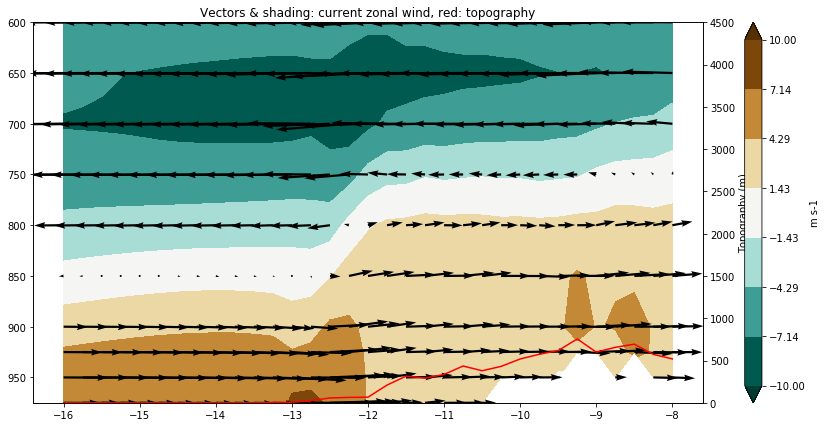

In [46]:
# zonal wind, currently and wind differences
twinx = {'x' : past_cross.lon, 'y' : tpick, 'color' : 'red', 'ylabel' : 'Topography (m)', 'ylim' : (0,4500)}

data = (cur_cross['u_pl'] - past_cross['u_pl'])
draw_cross((cur_cross['u_pl']), past_cross.lon, past_cross.p_lev, cmap='BrBG_r', levels=np.linspace(-10,10,8), 
           quiver=qin, cbar_label='m s-1', twinx=twinx, 
           title='Vectors & shading: current zonal wind, red: topography')

In [47]:
# differences in wind vectors
uano = cur_cross['u_pl']-past_cross['u_pl']
wano = cur_cross['w_pl']-past_cross['w_pl']*10
st=30
sarrow = 4
xquiv = cur_cross.lon#[sarrow::st, sarrow::st]
yquiv = cur_cross.p_lev#[sarrow::st, sarrow::st]

uu = (uano)#[sarrow::st, sarrow::st]  # wind differences
ww = (wano)#[sarrow::st, sarrow::st]

qin = {'x' : xquiv, 'y' : yquiv, 'u' : uu, 'v' : ww, 'scale' : 30}

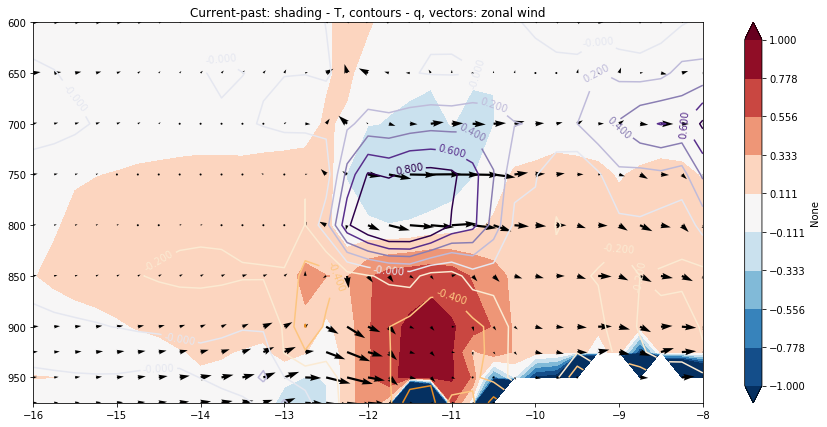

In [48]:
# temperature and moisture check
data = (cur_cross['q_pl'] - past_cross['q_pl'])*1000
contour = {'data' : data, 'x' : past_cross.lon, 'y' : past_cross.p_lev, 'levels' : np.arange(-1,1,0.2), 'cmap' : 'PuOr'}
draw_cross((cur_cross['T_pl'] - past_cross['T_pl']), past_cross.lon, past_cross.p_lev, cmap='RdBu_r', 
           levels=np.linspace(-1,1,10), quiver=qin, contour=contour, title='Current-past: shading - T, contours - q, vectors: zonal wind')

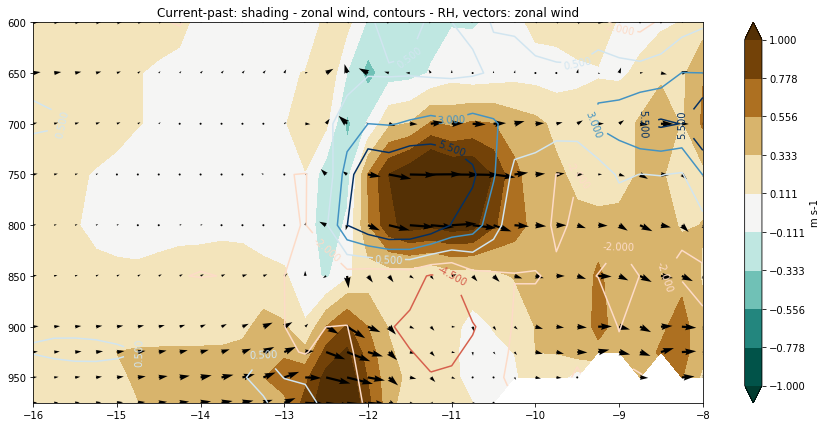

In [49]:
# zonal wind shading and relative humidity
data = (cur_cross['rh_pl']-past_cross['rh_pl'])
contour = {'data' : data, 'x' : data.lon, 'y' : data.p_lev, 'levels' : np.arange(-7,7.1,2.5), 'cmap' : 'RdBu'}
draw_cross((cur_cross['u_pl']-past_cross['u_pl']), past_cross.lon, past_cross.p_lev, cmap='BrBG_r', levels=np.linspace(-1,1,10), 
           quiver=qin, contour=contour, title='Current-past: shading - zonal wind, contours - RH, vectors: zonal wind', cbar_label='m s-1')

Other things to check: changes in shallow convection / shallow cloud development? Impact on incoming radiation? ..